In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandarallel
from scipy.optimize import curve_fit
from scipy import signal
from scipy.signal import sawtooth
import os
from typing import Optional,Dict
import numpy as np
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
import  cmcrameri.cm as cmc
import matplotlib as mpl
from scipy import signal
from scipy.signal import sawtooth


In [2]:



class SpEC:
    def __init__(self,
                 Wavelength: Optional[np.ndarray] = None,
                 Andorspec: Optional[pd.DataFrame] = None,
                 Andorspec_calibrated: Optional[pd.DataFrame] = None,
                 CV: Optional[pd.DataFrame] = None,
                 interpolation: Optional[Dict] = None,
                 meta_data: Optional[Dict] = None,
                 spec_scans: Optional[Dict] = None,
                 spec_scans_downsampled: Optional[Dict] = None,
                 CV_scans: Optional[Dict] = None,
                 ):
        self.Wavelength = Wavelength if Wavelength is not None else np.array([])
        self.Andorspec = Andorspec if Andorspec is not None else pd.DataFrame()
        self.Andorspec_calibrated = Andorspec_calibrated if Andorspec_calibrated is not None else pd.DataFrame()
        self.CV = CV if CV is not None else pd.DataFrame()
        self.interpolation = interpolation if interpolation is not None else {}
        self.meta_data = meta_data if meta_data is not None else {}
        self.spec_scans = spec_scans if spec_scans is not None else {}
        self.CV_scans = CV_scans if CV_scans is not None else {}
        self.spec_scans_downsampled = spec_scans_downsampled if spec_scans_downsampled is not None else {}

    def read_CV(self, CV_file_path: Path):
        self.CV = pd.read_csv(CV_file_path)
        # the first collum from the CV is not meaningful drop it
        self.CV = self.CV.drop(self.CV.columns[0], axis=1)
        # make the 'Cycl' collumn of type int
        try:
            self.CV['Cycle'] = self.CV['Cycle'].astype(int)
        except ValueError as e:
            print('The CV file does not have a "Cycle" column, please check this data')
            raise e
        
        return self.CV,
    def generate_interpolation_function(self, 
                                        startin_amp: float = -1,
                                          starting_phase: float = 0):
        """
        This function reads the CV attribute of self. It reads the collumns 
        't_s'	and 'Ewe_V' and fits these functions to Sawtooth2. It populates the 
        interpolation attribute of self with the interpolation function. This can
        then be used to convert time to voltage in spectral data. If the fit is poor
        the user can adjust the starting amplitude and phase, most likley the issue
        is the amplitude - change this from -1 to 1
        """

        # catch if the CV attribute is empty
        if self.CV is None or self.CV.empty:
            print('The CV attribute is empty, please read the CV data first')
            return
        
        # call the CV attribute and group by ["Cycle"]. Select cycle 0
        CV = self.CV

        # extract the time and voltage data from the collumns 't_s' and 'Ewe_V'
        # as x_data and y_data respectively
        x_data = CV['t_s']
        y_data = CV['Ewe_V']
        max_cycles=int(CV['Cycle'].max())
        # Initial guess for the parameters [amplitude, phase], period is the max time
        initial_guess = [ startin_amp, x_data.max()/max_cycles, starting_phase]

                # Fit the data to the custom sawtooth function
        popt, pcov = curve_fit(
            sawtooth2, 
            x_data, 
            y_data, 
            p0=initial_guess, 
            method='dogbox', 
            maxfev=100000  # Increase the number of iterations
        )
        # Extract the optimal parameters
        amplitude_fit, period_fit, phase_fit = popt

        # Print the fitted parameters
        print(f"""Fitted parameters saved to the interpolation attribute are:
        Amplitude:{amplitude_fit}
        Period:{period_fit}
        Phase: {phase_fit} 
        by passing (time_array, fitted parametes) you can interpolate t-->V
        NOTE this function is only as accurate as the CV's sampling rate
        by rounding the values to the parameters used you will get the best result 
        """)

        # Generate fitted data
        y_fit = sawtooth2(x_data, amplitude_fit, period_fit, phase_fit)

        # Plot the original data and the fitted data
        fig, ax = plt.subplots()
        ax.plot(x_data, y_data , label='Original data')
        ax.plot(x_data, y_fit, color='red', linestyle='--', label='Fitted data')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (V)')
        # add a title of fitted vs measured time/ voltage 
        plt.title('Interpolation function used to covert t to V')

        # add ledgend and place it on outside of plot on the right
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()



        self.interpolation = (amplitude_fit, period_fit, phase_fit)
        return self.interpolation
        
        
    def read_Andorspec(self, Andorspec_file_path: Path):
        """This function reads the Andorspec pkl file
        as a datadrame. As the spectral times overrun the CV times
        this function removes the spectral data that is not in the CV
        This dataframe then populates the Andorspec attribute of self
        """
        data = pd.read_pickle(Andorspec_file_path)
        # remove the spectral data that is not in the CV
        data_trimmed = data[data.index <= self.CV["t_s"].max()]
        # name the index of the Andorspec dataframe as 'Time_s'
        data_trimmed.index.name = 'Time (s)'
        # Name the collumns of the Andorspec dataframe as 'Wavelength'
        data_trimmed.columns.name = 'Wavelength (nm)'

        self.Andorspec = data_trimmed
        return self.Andorspec
    
    def Calibrate_Andorspec(self):
        """This function combines the cycle_calculator and scan_direction_calculator code. It takes in a SpEC object
        it returns the Andorspec_calibrated attribute of the SpEC object. This is calculated by first trimming the
        Andorspec attribute of the SpEC object to the minimum time value of the CV attribute. The function then
        calculates the cycle and scan direction of the spectral data. These are added as collumns to the Andorspec_calibrated object"""
        Andoor_spec_calibrated = self.Andorspec.copy(deep=True)

        # we remove any values where the camera reads earlier than the potentostat or later than the potentostat
        # the former can happen because the gamry appears to send the trigger signal before it starts sending data
        # and we don't know what it does in this time. The latter can happen because the gamry can end before
        # async's poll can send the stop command
        Andoor_spec_calibrated=Andoor_spec_calibrated[(Andoor_spec_calibrated.index >= self.CV['t_s'].min()) 
                                                      & (Andoor_spec_calibrated.index <= self.CV['t_s'].max())]
        

        # there is also the case where the CV goes on for longer than the camera. We need to remove these values
        # because they produce errors in the cycle calculation later
        CV=self.CV.copy(deep=True)
        #CV = self.CV[self.CV['t_s'] <= Andoor_spec_calibrated.index.max()]
        time_array=Andoor_spec_calibrated.index.values
        #create an empty array of the same length as the time array and fill it with NaN

        cycle = np.full(len(time_array), np.nan)

        #group the CV by cycle
        grouped = CV.groupby(["Cycle"])
        #iterate through each cycle

        for i, group in grouped:
            #get the maximum and minimum time values of the cycle
            max_time = group["t_s"].max()
            min_time = group["t_s"].min()
            #print(f'max time is {max_time}')
            #on the first cycle set the cycle number only as time_array <= max_time
            if i[0] == 0:
                cycle[time_array <= max_time] = i[0]
            
            elif i[0] != 0:
                #set the cycle value of the time array to the cycle number
                cycle[(time_array >= min_time) & (time_array <= max_time)] = i[0]
        
        # add cycle as a new collumn to the Andorspec_calibrated dataframe
        Andoor_spec_calibrated.insert(0, 'Cycle', cycle)


        # calculate the derivative of the sawtooth2 function
        deriv = np.diff(sawtooth2(time_array, *self.interpolation)) > 0
        # insert the first value of the derivative to the start of the array because np.diff reduces the length by 1
        deriv = np.insert(deriv, 0, deriv[0])

        plt.plot(time_array, deriv)

        # set the x label to Time (s)

        plt.xlabel('Time (s)')
        plt.ylabel('Predicted scan Direction, 1=anodic scan')
        plt.title('Predicted scan direction from the fitting of U vs t')
        # Initialize scan_direction as an array of strings instead of zeros
        scan_direction = np.full(len(time_array), '', dtype=object)

        # Set the scan direction to 'anodic' if the derivative is greater than zero
        scan_direction[deriv] = 'anodic'
        # Set the scan direction to 'cathodic' if the derivative is less than zero
        scan_direction[~deriv] = 'cathodic'


        # add scan_direction as a new collumn to the Andorspec_calibrated dataframe
        Andoor_spec_calibrated.insert(1, 'Scan Direction', scan_direction)

        #Finally use the index of of Andoor_spec_calibrated to apply the interpolation function to the Andorspec_calibrated
        U=sawtooth2(Andoor_spec_calibrated.index.values, *self.interpolation)
        # insert the voltage as a new collumn to the Andorspec_calibrated dataframe
        Andoor_spec_calibrated.insert(2, 'Voltage (V)', U)
        self.Andorspec_calibrated = Andoor_spec_calibrated
        self.CV = CV

        # finally there can be a case where the 
        return self.Andorspec_calibrated,  self.CV
    
    def populate_spec_scans(self):
        """This function reads the Andorspec_calibrated attribute of the SpEC object. It groups the data by cycle
        and then by scan direction. It then populates the spec_scans attribute of the SpEC object with a dictionary of dictionaries.
        The first key is the cycle number, the second key is the scan direction. The value is the dataframe of the spectral data
        for that cycle and scan direction. You may need to correct for anomalies in the interpolation function using the 
        remove_scan_outliers function"""
        
        cycle_dict={}
        for i in range(int(self.Andorspec_calibrated['Cycle'].max()+1)):
            temp=self.Andorspec_calibrated.groupby(["Cycle"]).get_group((i,))
            Anodic=temp.groupby(["Scan Direction"]).get_group(('anodic',)).drop('Scan Direction', axis=1).drop('Cycle', axis=1)
            
            try:
                Anodic=temp.groupby(["Scan Direction"]).get_group(('anodic',)).drop('Scan Direction', axis=1).drop('Cycle', axis=1)
            except Exception as e:
                Anodic=None
                print(f'no anodic data in scan number {i}, {e} scan data set to None' )
            try:
                Cathodic=temp.groupby(["Scan Direction"]).get_group(('cathodic',)).drop('Scan Direction', axis=1).drop('Cycle', axis=1)
            except Exception as e:
                print(f'no cathodic data in scan number {i}, {e} scan data set to None')
                Cathodic=None
            cycle_dict[i]={'Anodic': Anodic, 'Cathodic': Cathodic}
        self.spec_scans=cycle_dict
        return self.spec_scans 
        

        
    def Downsample_spec_scans(self, voltage_resolution:float, Wavelength_resolution:int, show_times:bool=False, transpose:bool=True):
        """This function takes in the spec_scans attribute of the SpEC object. It loops through the dictionary of dictionaries
        and calls the Downsample_Potential and Downsample_Wavelength functions on each dataframe in the dictionary. The downsampled
        dataframes are then stored in the spec_scans_downsampled attribute of the SpEC object as a dictionary of dictionaries like the
        spec_scans attribute"""

        cycle_dict={}
        for key, value in self.spec_scans.items():
            temp_dict={}
            for key2, value2 in value.items():
    
                if key2 == 'Anodic' and value2 is not None:
                    temp=Downsample_Wavelength(value2, Wavelength_resolution)
                    temp_dict['Anodic']=Downsample_Potential(temp, voltage_resolution)
                    temp_dict['Anodic'].columns.name='Wavelength (nm)'
                    temp_dict['Anodic'].index.name='Voltage (V)'
                    temp=None
                    if not show_times:
                        # pop the Time (s) collumn
                        temp_dict['Anodic'].pop('Time (s)')
                    
                    if transpose:

                        temp_dict['Anodic']=temp_dict['Anodic'].T
                        
                elif key2 == 'Cathodic' and value2 is not None:
                    temp=Downsample_Wavelength(value2, Wavelength_resolution) 
                    temp_dict['Cathodic']=Downsample_Potential(temp, voltage_resolution)
                    temp_dict['Cathodic'].columns.name='Wavelength (nm)'
                    temp_dict['Cathodic'].index.name='Voltage (V)'
                    temp=None

                    if not show_times:
                        temp_dict['Cathodic'].pop('Time (s)')
                        
                    if transpose:
                        temp_dict['Cathodic']=temp_dict['Cathodic'].T
                        
            cycle_dict[key]=temp_dict
        self.spec_scans_downsampled=cycle_dict


        return self.spec_scans_downsampled

def select_file_path():
    """ This is the base function to select a file, it opens a prompt and returns
    a path obect.
  
    """
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename()  # Show the file dialog and get the selected file path
    root.destroy()  # Close the root window
    return Path(file_path)

def change_directory_to_new_expt():
    "If you keep filenames constant and specifically name folders you can set the\
        directory to the new folder by selecting a file in that folder"
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = Path(filedialog.askopenfilename()).parent  # Show the file dialog and get the selected file path
    root.destroy()  # Close the root window
    return os.chdir(file_path)


def sawtooth2(time, amplitude, period, phase):
    """ This function generates a sawtooth wave with the following parameters:
    Once, fitted is used to generate an interpolation function from t-->V.
    time: time array
    amplitude: amplitude of the wave
    period: period of the wave
    phase: phase of the wave
    """
    return amplitude * sawtooth((2*np.pi  * time)/(period)-phase, 0.5)


def Downsample_Potential(SpEC_scans_dataframe, voltage_resolution:float):
    """This function takes in the a single dataframe from spec_cycles. It averages rows that are within the voltage resolution of one another
    The function returns a downsampled dataframe"""
    
    all_spectra=SpEC_scans_dataframe

    # extract the times from the index

    times = all_spectra.index.values.astype(float)

    # insert this into the 0th collumn of the dataframe

    all_spectra.insert(0, 'Time (s)', times)

    all_spectra = all_spectra.dropna()


    # create a array with the same number of value as the voltage (V) collumn
    # this array will be used to group the data by voltage resolution

    voltage_grouping = all_spectra['Voltage (V)'].copy(deep=True)


    # round the voltage grouping array to the nearest voltage resolution

    voltage_grouping = np.round(voltage_grouping / voltage_resolution) * voltage_resolution

    # replace the voltage collumn with the rounded voltage grouping array

    all_spectra['Voltage (V)'] = voltage_grouping

    # perform the mean downsample by grouping the data by the voltage collumn and taking the mean

    all_spectra = all_spectra.groupby('Voltage (V)').mean()

    return all_spectra

def Downsample_Wavelength(SpEC_scans_dataframe, Wavelength_resolution:int):
    """This function takes in the a single dataframe from spec_cycles. It averages rows that are within the voltage resolution of one another
    The function returns a downsampled dataframe"""
    

    all_spectra=SpEC_scans_dataframe.copy(deep=True)

    all_spectra.columns.name=None


    # temporarilty pop the voltage collumn to perform the downsample

    voltages = all_spectra.pop('Voltage (V)')

    wavelengts=all_spectra.columns.values

    # convert all wavelengths values to floats

    wavelengts = wavelengts.astype(float)

    wavelength_grouping = np.round(wavelengts / Wavelength_resolution) * Wavelength_resolution

    #set the values of the collumn names to wavelength_grouping

    all_spectra.columns = wavelength_grouping

    all_spectra = all_spectra.T.groupby(wavelength_grouping).mean().T
    # set the type of the collumn names to int

    all_spectra.columns = all_spectra.columns.astype(int)

    # add the voltage collumn back to the dataframe

    all_spectra.insert(0, 'Voltage (V)', voltages)

    return all_spectra


def calculateDOD(SpEC_object: SpEC, cycle_number:int, scan_direction:str,Referance_potential:float, smooth_strength:int=0):
    """This function calculates Delta OD for a single cycle and scan direction. If the referance potential
    given is not present the nearest potential is used. The function returns a dataframe. If smooth_strength is set to 0
    the function returns the raw data. If smooth_strength is an odd integer the function returns the data smoothed by a golay function"""
    if scan_direction not in ['Anodic', 'Cathodic']:
        print('scan_direction must be either "Anodic" or "Cathodic"')
        return

    # extract the spectral data for the cycle and scan direction

    data = SpEC_object.spec_scans_downsampled[cycle_number][scan_direction]

    # extract the voltages - which are the collumn names
    voltages=data.columns.values
    #print(voltages)


    # find the nearest potential to the referance potential

    nearest_potential_index= np.argsort(np.abs((voltages - Referance_potential)))[0]


    # extract the data at the nearest potential

    I0=data.iloc[:, nearest_potential_index]
    LnI0= np.log10(I0)
    LnI= pd.DataFrame(np.log10(data))
    #print(LnI.shape)

    DOD=-1*LnI.subtract(LnI0, axis=0)

    if smooth_strength != 0:
        DOD=DOD.apply(lambda x: signal.savgol_filter(x, smooth_strength, 3), axis=0)

    return DOD, Referance_potential
    

def plot_DOD(DOD_dataframe: pd.DataFrame,
            Title: Optional[str] = None,
            y_max: Optional[float]=None,
            y_min: Optional[float]=None,
            x_max: Optional[float]=None,
            x_min: Optional[float]=None,
            reference_potential: Optional[float]=None
            ):
    """This function takes in a DOD dataframe and plots it. The function returns a plot"""
    # get the number of collumns in DOD
    n=DOD_dataframe.shape[1]
    # get the color map
    
    cmap = cmc.roma

    colors=cmap(np.linspace(0,1,n))
    #remove the first 100 rows
    colors=np.linspace(0,1,n)
    colors=cmc.roma(colors)

    fig, ax = plt.subplots()
    for i in range(n):
        ax.plot(DOD_dataframe.index, DOD_dataframe.iloc[:, i], color=colors[i], linewidth=2)

    v_min=DOD_dataframe.columns.min()
    v_max=DOD_dataframe.columns.max()
        # Normalize the color map
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax, label='$U (V) $')
    

    plt.xlabel('Wavelength (nm)', fontsize=21)
    # set the y label to f"$\Delta$A (O.D. vs {reference_potential} V)" if reference_potential is not None else f"$\Delta$A (O.D.)"
    plt.ylabel(f"$\Delta$A (O.D. vs {reference_potential})" if reference_potential is not None else f"$\Delta$A (O.D.)", fontsize=18)

    # set the axis font size to 20
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if Title is not None:
        plt.title(Title, fontsize=21)
    if y_max is not None and y_min is not None:
        plt.ylim(top=y_max, bottom=y_min)

    if x_min is not None and x_max is not None:
        plt.xlim(left=x_min, right=x_max)
    
    return fig, ax


def Co_plot_DOD_and_CV(DOD_dataframe: pd.DataFrame,
            CV_dataframe: pd.DataFrame,
            Title: Optional[str] = None,
            y_max: Optional[float]=None,
            y_min: Optional[float]=None,
            x_max: Optional[float]=None,
            x_min: Optional[float]=None,
            reference_potential: Optional[float]=None,
            scan_direction: Optional[str]=None):
    """This function takes in a DOD dataframe and plots it. The function returns a plot"""
    # get the number of collumns in DOD
    n=DOD_dataframe.shape[1]
    # get the color map
    
    cmap = cmc.roma

    colors=cmap(np.linspace(0,1,n))
    #remove the first 100 rows
    colors=np.linspace(0,1,n)
    colors=cmc.roma(colors)

    fig, ax = plt.subplots(2,1)
    for i in range(n):
        ax[0].plot(DOD_dataframe.index, DOD_dataframe.iloc[:, i], color=colors[i], linewidth=2)

    v_min=DOD_dataframe.columns.min()
    v_max=DOD_dataframe.columns.max()
        # Normalize the color map
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax[0], label='$U (V) $')
    

    ax[0].set_xlabel('Wavelength (nm)', fontsize=12)
    # set the y label to f"$\Delta$A (O.D. vs {reference_potential} V)" if reference_potential is not None else f"$\Delta$A (O.D.)"
    ax[0].set_ylabel(f"$\Delta$A (O.D. vs {reference_potential})" if reference_potential is not None else f"$\Delta$A (O.D.)", fontsize=12)

    # set the axis font size to 20
    #ax[0].set_xticks(fontsize=18)
    #ax[0].set_yticks(fontsize=18)
    # set the axis fontsixe

    if Title is not None:
        fig.suptitle(Title, fontsize=21)
    if y_max is not None and y_min is not None:
        ax[0].set_ylim(top=y_max, bottom=y_min)

    if x_min is not None and x_max is not None:
        ax[0].set_xlim(left=x_min, right=x_max)

    #ax[1].plot(CV_dataframe['Ewe_V'], CV_dataframe['I_A'])

    # extract the voltage and current data from the CV dataframe as a new dataframe
    CV = CV_dataframe[['Ewe_V', 'I_A']]
    num_points = CV.shape[0]  # Assuming CV is a list or array of points
    cmap = cmc.roma

    colors=cmap(np.linspace(0,1,num_points))
    #remove the first 100 rows
    colors=np.linspace(0,1,num_points)
    colors=cmc.roma(colors)    #remove the first 100 rows

    print(CV.shape)
    for i in range(num_points - 2):
            
            if scan_direction is not None and scan_direction == 'Anodic':
                ax[1].plot(CV.iloc[i:i+2, 0], CV.iloc[i:i+2, 1], color=colors[i])
            elif scan_direction is not None and scan_direction == 'Cathodic':    
                ax[1].plot(CV.iloc[i:i+2, 0], CV.iloc[i:i+2, 1], color=colors[-i])
        






    ax[1].set_xlabel('U (V)', fontsize=12)

    ax[1].set_ylabel('I (A)', fontsize=12)
    if scan_direction is not None and scan_direction == 'Anodic':
        ax[1].annotate('Scan direction', xy=(0.5, 1.08), xytext=(0.3, 1.08),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                ha='center', va='center', fontsize=16, xycoords='axes fraction', textcoords='axes fraction')
    if scan_direction is not None and scan_direction == 'Cathodic':
        ax[1].annotate('Scan direction', xy=(0.3, 1.08), xytext=(0.5, 1.08),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                ha='center', va='center', fontsize=16, xycoords='axes fraction', textcoords='axes fraction')


    #ax[1].xticks(fontsize=18)

    #ax[1].yticks(fontsize=18)

    # use tight layout to prevent overlap of the two plots
    plt.tight_layout()  
    plt.show()

    




def normalise_DOD (DOD_dataframe: pd.DataFrame):
    """This function takes in a DOD dataframe and normalises it to the maximum value of each collumn. The function returns a normalised DOD dataframe"""
    # write a lambda fucnction that normalises each collumn of a dataframe by the maximum value of that collumn
    normalise = lambda x: x / x.max()
    # apply the normalise function to the DOD dataframe
    DOD_normalised = DOD_dataframe.apply(normalise, axis=0)
    
    return DOD_normalised


/Users/benj/Documents/HiSpEC-analysis/new/Bentham/ANDORSPEC-0.0.0.0__0.pkl 
 /Users/benj/Documents/HiSpEC-analysis/new/Bentham/CV-3.3.0.0__0.csv
Fitted parameters saved to the interpolation attribute are:
        Amplitude:1.0009394360417019
        Period:400.0003683148875
        Phase: 0.00014585976212695456 
        by passing (time_array, fitted parametes) you can interpolate t-->V
        NOTE this function is only as accurate as the CV's sampling rate
        by rounding the values to the parameters used you will get the best result 
        


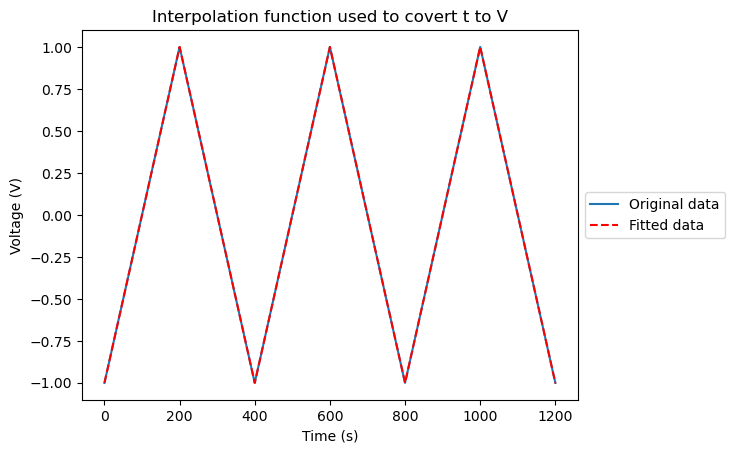

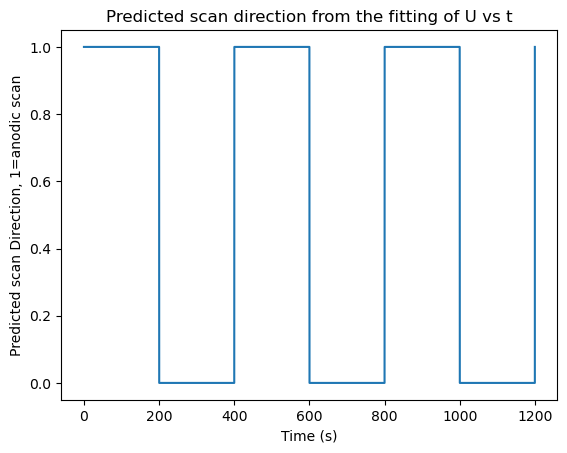

In [3]:
if __name__ == "__main__":
    AndorPath = select_file_path()
    CV_path = select_file_path()
    print(AndorPath, "\n", CV_path)   

    SpEC1 = SpEC()
    SpEC1.read_CV(CV_path)
    SpEC1.generate_interpolation_function()
    SpEC1.read_Andorspec(AndorPath)
    SpEC1.Calibrate_Andorspec()
    SpEC1.populate_spec_scans()
    SpEC1.Downsample_spec_scans(0.005, 1)

In [155]:
test=SpEC1.Andorspec_calibrated

test

Wavelength (nm),Cycle,Scan Direction,Voltage (V),399.992645,400.206268,400.419922,400.633545,400.847198,401.060791,401.274445,...,939.882324,940.091309,940.300293,940.509399,940.718384,940.927307,941.136353,941.345337,941.554321,941.763306
Time (s),,,,,,,,,,,,,,,,,,,,,
0.010200,0.0,anodic,-1.000909,687977,635925,632134,641430,645406,654764,664217,...,913529,907193,909287,908070,903762,902775,900515,902486,893212,857227
0.020401,0.0,anodic,-1.000399,686146,632777,632747,642726,643826,655098,664423,...,911934,908837,911530,904434,906833,902506,900795,901918,890409,852801
0.030601,0.0,anodic,-0.999888,687088,633860,633187,639397,643371,654213,662699,...,911315,906331,906199,903983,904838,899834,901891,899825,888603,854636
0.040801,0.0,anodic,-0.999378,686666,633980,637216,642378,645131,655511,664999,...,915921,908968,908573,907756,908412,904530,903563,899463,893135,855593
0.051002,0.0,anodic,-0.998867,687754,635477,633936,640593,643775,653542,665163,...,916994,910045,910575,908637,907512,906743,902428,902782,893829,855068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239.973152,2.0,cathodic,-0.999094,775238,717538,716285,723536,728134,738612,748557,...,989409,983169,984543,983190,980565,979301,975251,979886,965073,927249
239.983353,2.0,cathodic,-0.999604,773710,718462,716726,724976,726640,739469,749124,...,993856,985507,986279,982067,979123,979632,979091,981653,969934,928504
239.993553,2.0,cathodic,-1.000115,776665,716591,715986,723653,729630,740778,749624,...,991729,982521,989249,985340,983388,979477,980429,982775,970941,929035


In [149]:
SpEC1.spec_scans_downsampled[0]['Cathodic']

Voltage (V),-1.000,-0.995,-0.990,-0.985,-0.980,-0.975,-0.970,-0.965,-0.960,-0.955,...,0.955,0.960,0.965,0.970,0.975,0.980,0.985,0.990,0.995,1.000
Wavelength (nm),,,,,,,,,,,,,,,,,,,,,
400,677865.388889,677754.100,677612.966667,677679.633333,677164.800,677325.148148,677257.633333,677072.766667,676913.166667,677460.333333,...,653594.066667,653756.800,653323.566667,653621.555556,653520.700,654156.066667,653933.60,653800.600,654471.555556,655103.285714
401,679166.266667,679933.140,679050.940000,679448.220000,679200.240,678916.022222,678932.360000,678621.300000,679306.940000,679287.760000,...,655559.140000,655289.100,655141.860000,655373.755556,655684.400,656006.980000,655679.14,655742.260,655995.422222,656618.628571
402,709562.750000,709969.975,709635.650000,709566.375000,709233.175,709015.888889,709578.900000,709250.100000,709326.575000,709658.600000,...,684284.475000,684337.425,684223.775000,684632.555556,684499.325,685266.675000,684704.85,684793.575,684911.555556,685904.321429
403,745314.500000,745777.140,744640.260000,745337.720000,744685.940,744894.377778,744483.440000,743988.320000,744558.000000,744826.480000,...,718481.280000,718333.500,718525.360000,718728.111111,718859.400,718748.620000,719044.68,718751.020,719318.755556,720288.400000
404,782369.866667,783146.940,782146.680000,782230.260000,782147.120,782078.200000,782122.540000,781519.620000,782246.720000,782317.360000,...,754564.700000,754679.580,754709.600000,754641.288889,754765.000,754974.640000,754898.68,755199.980,755079.177778,755595.514286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,932361.133333,932537.580,932124.280000,931745.140000,932831.440,932148.511111,932722.360000,932233.800000,931870.940000,932161.860000,...,915072.000000,915559.040,915330.000000,915342.977778,914960.560,914993.920000,914720.60,915021.920,914727.155556,915712.028571
939,924343.866667,924394.060,924297.740000,924592.360000,924800.100,924460.577778,924287.100000,923947.640000,923966.620000,923931.180000,...,906572.120000,907199.180,906784.340000,906985.488889,906412.320,906865.160000,906530.18,906801.040,907098.644444,907966.685714
940,910801.791667,910548.925,910804.425000,910749.375000,910840.075,911020.250000,911160.525000,910408.725000,910433.400000,910706.375000,...,893960.450000,893870.525,893582.400000,893966.333333,893493.375,893859.575000,893016.10,893851.075,893183.638889,895119.785714


In [150]:
SpEC1.spec_scans_downsampled[0].keys()

dict_keys(['Anodic', 'Cathodic'])

Voltage (V),-1.000,-0.995,-0.990,-0.985,-0.980,-0.975,-0.970,-0.965,-0.960,-0.955,...,0.955,0.960,0.965,0.970,0.975,0.980,0.985,0.990,0.995,1.000
Wavelength (nm),,,,,,,,,,,,,,,,,,,,,
400,-0.014834,-0.014762,-0.014672,-0.014715,-0.014385,-0.014487,-0.014444,-0.014326,-0.014223,-0.014574,...,0.001002,0.000894,0.001181,0.000983,0.001050,0.000628,0.000776,0.000864,0.000419,-0.0
401,-0.014663,-0.015153,-0.014589,-0.014843,-0.014685,-0.014503,-0.014513,-0.014314,-0.014753,-0.014741,...,0.000701,0.000880,0.000978,0.000824,0.000618,0.000405,0.000622,0.000580,0.000412,-0.0
402,-0.014727,-0.014976,-0.014772,-0.014729,-0.014526,-0.014392,-0.014737,-0.014536,-0.014583,-0.014786,...,0.001027,0.000993,0.001065,0.000806,0.000891,0.000404,0.000760,0.000704,0.000629,-0.0
403,-0.014833,-0.015103,-0.014440,-0.014847,-0.014467,-0.014588,-0.014349,-0.014060,-0.014392,-0.014549,...,0.001091,0.001180,0.001064,0.000942,0.000862,0.000929,0.000751,0.000928,0.000585,-0.0
404,-0.015123,-0.015554,-0.014999,-0.015045,-0.014999,-0.014961,-0.014985,-0.014651,-0.015054,-0.015094,...,0.000593,0.000527,0.000509,0.000549,0.000478,0.000357,0.000401,0.000227,0.000297,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,-0.007825,-0.007907,-0.007715,-0.007538,-0.008044,-0.007726,-0.007993,-0.007766,-0.007597,-0.007732,...,0.000304,0.000073,0.000181,0.000175,0.000357,0.000341,0.000470,0.000327,0.000467,-0.0
939,-0.007764,-0.007787,-0.007742,-0.007880,-0.007978,-0.007818,-0.007737,-0.007577,-0.007586,-0.007570,...,0.000668,0.000367,0.000566,0.000470,0.000744,0.000527,0.000688,0.000558,0.000415,-0.0
940,-0.007543,-0.007422,-0.007544,-0.007518,-0.007561,-0.007647,-0.007714,-0.007355,-0.007367,-0.007497,...,0.000563,0.000607,0.000747,0.000560,0.000790,0.000612,0.001022,0.000616,0.000940,-0.0


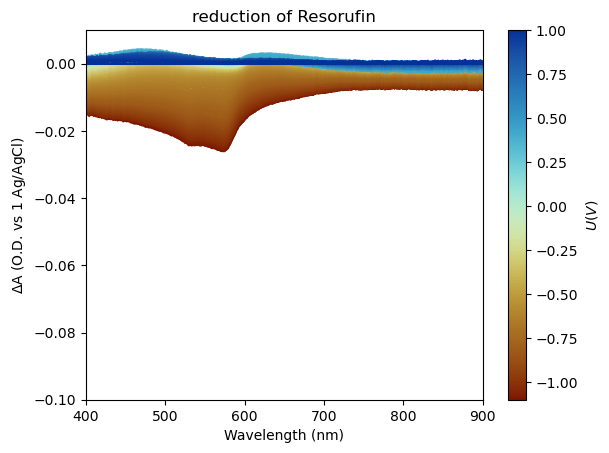

In [151]:

test=SpEC1.spec_scans_downsampled[0]['Cathodic']
# calcualte log10 of all collumns - log 10 of the first collumn
LnI=pd.DataFrame(np.log10(test))

LnI0=pd.DataFrame(np.log10(test.iloc[:,-1]))

DOD=-1*LnI.subtract(LnI0.iloc[:,0], axis=0)

# create a color map
n=DOD.shape[1]

cmap = cmc.roma

colors=cmap(np.linspace(0,1,n))
#remove the first 100 rows
colors=np.linspace(0,1,DOD.shape[1])
colors=cmc.roma(colors)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column of the DOD DataFrame
for i in range(DOD.shape[1]):
    ax.plot(DOD.index, DOD.iloc[:, i], color=colors[i], linewidth=1.5)

# Normalize the color map
norm = mpl.colors.Normalize(vmin=1, vmax=-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar to the figure
fig.colorbar(sm, ax=ax, label='$U (V) $')


# x axis is the voltage
# y axis is the $\Delta$OD
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\Delta$A (O.D. vs 1 Ag/AgCl)')
# set the y range from -0.0005 to 0.0005
plt.ylim(-0.1,0.01)
plt.xlim(400,900)
# add a title
plt.title('reduction of Resorufin')
DOD

(400.0, 860.0)

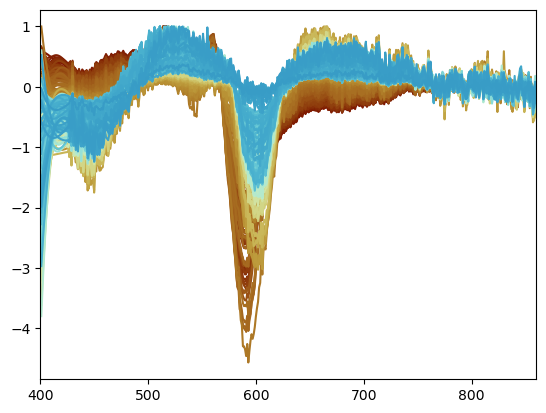

In [152]:
test2=SpEC1.spec_scans_downsampled[0]['Cathodic']


test3=pd.DataFrame(np.diff(DOD, axis=0))
# smooth each collumn of test 3 using a golay filter
for i in range(test3.shape[1]):
    test3.iloc[:,i]=signal.savgol_filter(test3.iloc[:,i], 51, 3)


# plot each collumn of test 3 agaisnt the index of test 2
fig, ax = plt.subplots()
for i in range(0,test3.shape[1]-100):
    ax.plot(test2.index[1:], test3.iloc[:, i]/np.min(test3.iloc[:,i]), color=colors[i], linewidth=1.5)

# set the x range from 400 to 900
plt.xlim(400,860)




Text(0, 0.5, '$-\\Delta$A (O.D. @ 575 nm vs 1 V Ag/AgCl)')

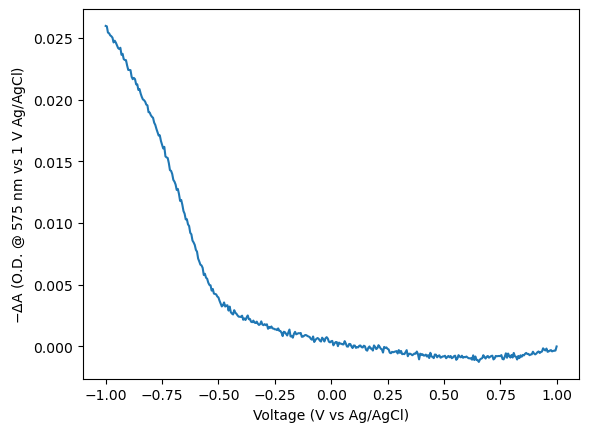

In [153]:
# get DOD at the index of 560 nm
DOD_560=(-1*DOD.loc[575]).plot()
# set the x label to Voltage
plt.xlabel('Voltage (V vs Ag/AgCl)')
# set the y label to $\Delta$OD
plt.ylabel('$-\Delta$A (O.D. @ 575 nm vs 1 V Ag/AgCl)')

# plot the DOD at 560 nm against the collumn names i.e. voltage


